In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.nn import Linear,ReLU
import torch.optim as optim
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/train.csv',index_col=0)
df.columns = [ i.replace(" ","") for i in df.columns]
df.head()

,CaseConditions_FeedRatetoC013(Input),CaseConditions_C7+inLightEnd(Input),CaseConditions_HeartCutProd.Rate(Input),CaseConditions_C6P-inHeartCut(Input),CaseConditions_FeedRatetoC013(Results),CaseConditions_C7+inLightEnd(Results),CaseConditions_HeartCutProd.Rate(Results),CaseConditions_C6P-inHeartCut(Results),CaseConditions_C10+inHeartCut(Results),NaphthaProperties_NaphthaFeedRate,...,HeavyEndProductProperties_3-Methylnonane,HeavyEndProductProperties_tert-Butylcyclohexane,HeavyEndProductProperties_n-Decane,"HeavyEndProductProperties_1,2-Diethylbenzene",HeavyEndProductProperties_n-Undecane,HeavyEndProductProperties_n-Pentylbenzene,HeavyEndProductProperties_n-Dodecane,HeavyEndProductProperties_n-Hexylbenzene,HeavyEndProductProperties_n-Tridecane,HeavyEndProductProperties_Overall
0,10.0,2.5,100.0,1.0,10.000001,2.500057,100.000198,1.000427,6.138641,118.000084,...,13.956123,2.497176,5.281883,3.507996,1.090498,0.220558,0.020529,0.041371,0.0,99.999993
1,10.0,5.0,100.0,1.0,10.000001,4.999882,100.000122,1.000401,6.249050,118.000000,...,14.167476,2.535975,5.369976,3.569902,1.111782,0.224973,0.020956,0.042241,0.0,100.000002
2,10.0,10.0,100.0,1.0,10.000001,10.000006,100.000008,0.999993,6.376052,118.000000,...,14.722088,2.637226,5.594396,3.724859,1.163364,0.235584,0.021969,0.044298,0.0,99.999983
3,10.0,2.5,100.0,1.5,10.000001,2.500020,100.000275,1.500293,6.316332,118.000000,...,12.408690,2.216235,4.679968,3.101526,0.961640,0.194369,0.018078,0.036421,0.0,100.000004
4,10.0,5.0,100.0,1.5,10.000001,5.000001,99.999817,1.499961,6.416863,118.000084,...,12.534007,2.239314,4.732872,3.139065,0.974726,0.197096,0.018343,0.036962,0.0,99.999999


In [3]:
all_col = df.columns.tolist()

In [4]:
Light = df.columns[df.columns.str.contains('LightEndProductProperties')].tolist()
Heart = df.columns[df.columns.str.contains('HeartCutProductProperties')].tolist()
Heavy = df.columns[df.columns.str.contains('HeavyEndProductProperties')].tolist()
y_col = Light+Heart+Heavy
print(len(y_col))

175


In [5]:
x_col = list(set(all_col)-set(y_col))
print(len(x_col))

99


# scale

In [6]:
mm = MinMaxScaler().fit(df[x_col])
df[x_col] = mm.transform(df[x_col]) 
df[x_col].head()

,CaseConditions_FeedRatetoC013(Input),NaphthaProperties_NaphthaFeedRate.1,NaphthaProperties_2-Methyloctane,NaphthaProperties_n-Dodecane,ColumnTempProfile_C013TrayBtmTemp,NaphthaProperties_Cyclohexane,NaphthaProperties_O-Xylene,NaphthaProperties_n-Pentane,CaseConditions_C6P-inHeartCut(Input),ColumnTempProfile_C013Tray12Temp,...,Feed_NaphthaFeedRatetoC011,NaphthaProperties_Methylcyclohexane,NaphthaProperties_n-Heptane,NaphthaProperties_Ethane,NaphthaProperties_n-Propylcyclohexane,"NaphthaProperties_1,2-Diethylbenzene",CaseConditions_HeartCutProd.Rate(Results),NaphthaProperties_Methane,NaphthaProperties_2-Methylhexane,NaphthaProperties_4-Methyl-1-hexene
0,0.0,0.270230,0.844858,0.080034,0.376246,0.10654,0.040867,0.011457,0.473684,0.553011,...,0.505320,0.007766,0.913178,0.0,0.436031,0.251093,0.499983,0.0,0.535118,0.499997
1,0.0,0.270228,0.844858,0.080034,0.375929,0.10654,0.040867,0.011457,0.473684,0.551027,...,0.505319,0.007766,0.913178,0.0,0.436031,0.251093,0.499980,0.0,0.535118,0.499997
2,0.0,0.270228,0.844858,0.080034,0.382411,0.10654,0.040867,0.011457,0.473684,0.552974,...,0.505319,0.007766,0.913178,0.0,0.436031,0.251093,0.499974,0.0,0.535118,0.499997
3,0.0,0.270228,0.844858,0.080034,0.333118,0.10654,0.040867,0.011457,0.736842,0.509968,...,0.505319,0.007766,0.913178,0.0,0.436031,0.251093,0.499987,0.0,0.535118,0.499997
4,0.0,0.270230,0.844858,0.080034,0.332291,0.10654,0.040867,0.011457,0.736842,0.508093,...,0.505320,0.007766,0.913178,0.0,0.436031,0.251093,0.499964,0.0,0.535118,0.499997


# dataset split and to tensor

In [7]:
from sklearn.model_selection import train_test_split

X = df[x_col].to_numpy()
y = df[y_col].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.float)
Y_test = torch.tensor(Y_test, dtype=torch.float)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

torch.Size([4559, 99])
torch.Size([1140, 99])
torch.Size([4559, 175])
torch.Size([1140, 175])


# net

In [8]:
def build_net(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,256),ReLU(),#INPUT LAYER
        Linear(256,256),ReLU(),#隱藏層
        Linear(256,256),ReLU(),#隱藏層
        Linear(256,output_shape)#OUTPUT LAYER
    )
    return net

def init_weights(m):
    if type(m) == Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0)

net = build_net(len(x_col),len(y_col))
net.apply(init_weights)

C:\Users\skywalker0803r\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':


Sequential(
  (0): Linear(in_features=99, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=175, bias=True)
)

# DataLoader

In [9]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Loss function and optimizer

In [10]:
loss_function = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.0001)

# Training and evaluation

In [11]:
def train(net,train_iter,loss_function,optimizer,num_epochs=500):
    history = []
    for epoch in range(num_epochs):
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # finish one epoch
        print("epochs {} loss {:.4f}".format(epoch,loss.item()))
        history.append(loss.item())
    # finish all epoch
    roll_num = int(len(history)/100)
    plt.plot(pd.Series(np.array(history)).rolling(roll_num).mean())
    plt.title('train loss')
    return net

epochs 0 loss 309.8592
epochs 1 loss 306.3536
epochs 2 loss 295.4081
epochs 3 loss 274.4308
epochs 4 loss 229.6493
epochs 5 loss 165.6747
epochs 6 loss 96.7044
epochs 7 loss 42.4794
epochs 8 loss 15.4144
epochs 9 loss 8.6284
epochs 10 loss 5.9317
epochs 11 loss 5.8930
epochs 12 loss 7.3041
epochs 13 loss 6.5447
epochs 14 loss 6.1036
epochs 15 loss 6.1052
epochs 16 loss 6.5774
epochs 17 loss 5.9332
epochs 18 loss 5.0699
epochs 19 loss 5.8513
epochs 20 loss 7.4899
epochs 21 loss 4.8333
epochs 22 loss 5.5442
epochs 23 loss 5.4412
epochs 24 loss 4.5261
epochs 25 loss 5.2464
epochs 26 loss 3.9748
epochs 27 loss 4.6191
epochs 28 loss 5.2020
epochs 29 loss 4.1600
epochs 30 loss 4.3300
epochs 31 loss 4.4259
epochs 32 loss 4.2633
epochs 33 loss 4.0915
epochs 34 loss 4.1958
epochs 35 loss 3.9946
epochs 36 loss 4.1894
epochs 37 loss 3.9061
epochs 38 loss 4.3368
epochs 39 loss 3.6444
epochs 40 loss 3.7477
epochs 41 loss 3.9590
epochs 42 loss 3.6510
epochs 43 loss 3.5356
epochs 44 loss 4.5697
epoch

epochs 360 loss 0.2326
epochs 361 loss 0.2371
epochs 362 loss 0.2621
epochs 363 loss 0.2607
epochs 364 loss 0.2742
epochs 365 loss 0.2251
epochs 366 loss 0.2847
epochs 367 loss 0.2389
epochs 368 loss 0.2280
epochs 369 loss 0.2188
epochs 370 loss 0.2406
epochs 371 loss 0.2551
epochs 372 loss 0.2403
epochs 373 loss 0.2459
epochs 374 loss 0.2893
epochs 375 loss 0.2580
epochs 376 loss 0.2315
epochs 377 loss 0.2189
epochs 378 loss 0.2178
epochs 379 loss 0.2333
epochs 380 loss 0.1976
epochs 381 loss 0.2535
epochs 382 loss 0.2244
epochs 383 loss 0.2218
epochs 384 loss 0.2495
epochs 385 loss 0.2129
epochs 386 loss 0.2352
epochs 387 loss 0.2265
epochs 388 loss 0.2182
epochs 389 loss 0.2071
epochs 390 loss 0.2114
epochs 391 loss 0.2172
epochs 392 loss 0.2171
epochs 393 loss 0.2253
epochs 394 loss 0.2079
epochs 395 loss 0.2038
epochs 396 loss 0.1928
epochs 397 loss 0.2203
epochs 398 loss 0.2253
epochs 399 loss 0.2394
epochs 400 loss 0.2004
epochs 401 loss 0.1982
epochs 402 loss 0.2018
epochs 403 

epochs 716 loss 0.0796
epochs 717 loss 0.0924
epochs 718 loss 0.0723
epochs 719 loss 0.0878
epochs 720 loss 0.0816
epochs 721 loss 0.0864
epochs 722 loss 0.0719
epochs 723 loss 0.0668
epochs 724 loss 0.0731
epochs 725 loss 0.0639
epochs 726 loss 0.0674
epochs 727 loss 0.0680
epochs 728 loss 0.0744
epochs 729 loss 0.0668
epochs 730 loss 0.0666
epochs 731 loss 0.0688
epochs 732 loss 0.0698
epochs 733 loss 0.0630
epochs 734 loss 0.0701
epochs 735 loss 0.0715
epochs 736 loss 0.0727
epochs 737 loss 0.0751
epochs 738 loss 0.0746
epochs 739 loss 0.0647
epochs 740 loss 0.0779
epochs 741 loss 0.0617
epochs 742 loss 0.0731
epochs 743 loss 0.0688
epochs 744 loss 0.0681
epochs 745 loss 0.0744
epochs 746 loss 0.0780
epochs 747 loss 0.0700
epochs 748 loss 0.0614
epochs 749 loss 0.0661
epochs 750 loss 0.0725
epochs 751 loss 0.0746
epochs 752 loss 0.0686
epochs 753 loss 0.0703
epochs 754 loss 0.0828
epochs 755 loss 0.0631
epochs 756 loss 0.0668
epochs 757 loss 0.0687
epochs 758 loss 0.0835
epochs 759 

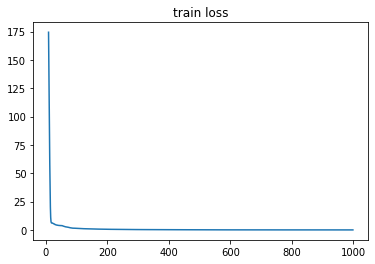

In [12]:
net = train(net,train_iter,loss_function,optimizer,1000)

In [31]:
y_pred = net(X_test).detach().numpy()
y_real = Y_test.numpy()

t = pd.DataFrame(columns=['R2'])

for idx,c in enumerate(y_col):
    t.loc[c,'R2'] = r2_score(y_real[:,idx],y_pred[:,idx])
t = t.clip(0,1)

In [33]:
t

,R2
LightEndProductProperties_LightEndProd.Rate,0.997187
LightEndProductProperties_LightEndProd.Rate.1,0.99654
LightEndProductProperties_C7+inLightEnd,0.997987
LightEndProductProperties_Oxygen,0
LightEndProductProperties_Methane,0
...,...
HeavyEndProductProperties_n-Pentylbenzene,0.944233
HeavyEndProductProperties_n-Dodecane,0
HeavyEndProductProperties_n-Hexylbenzene,0
HeavyEndProductProperties_n-Tridecane,0


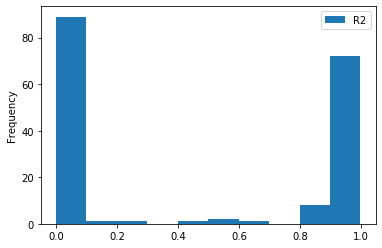

In [34]:
t.plot(kind='hist')

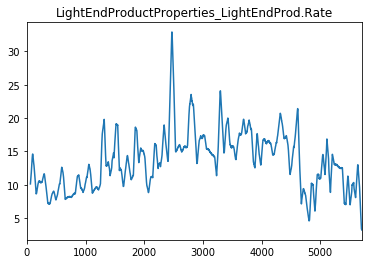

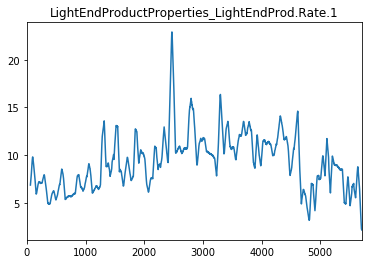

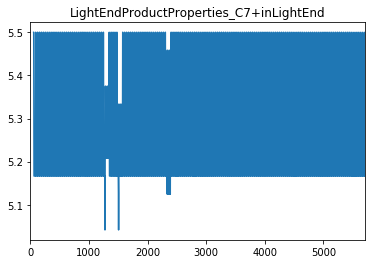

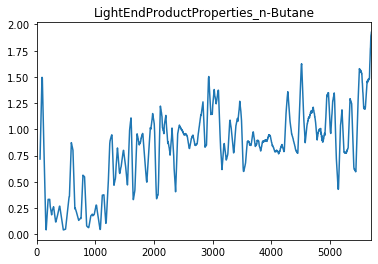

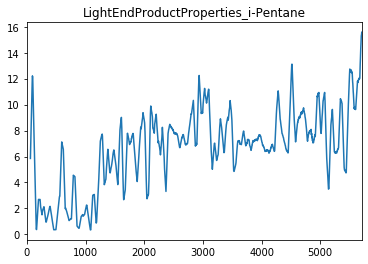

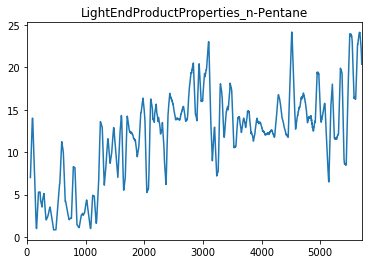

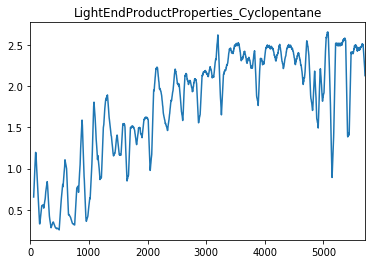

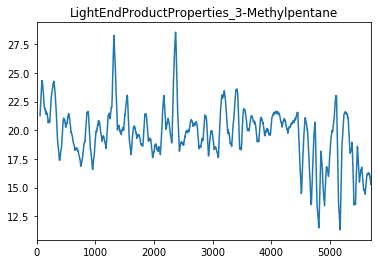

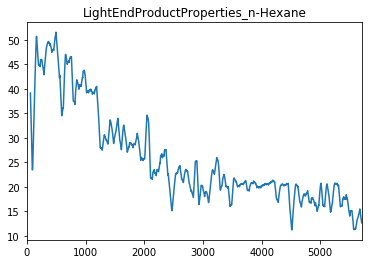

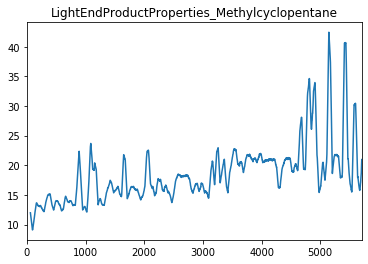

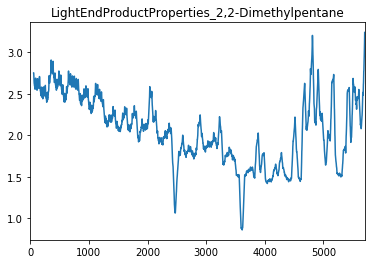

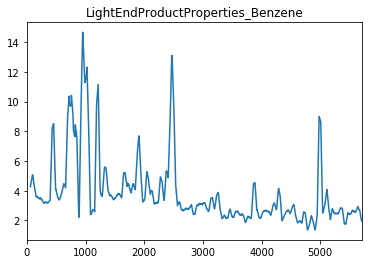

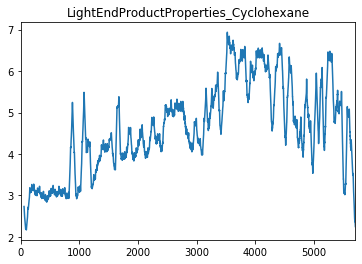

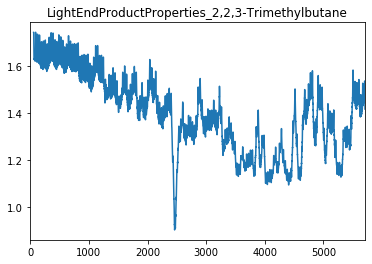

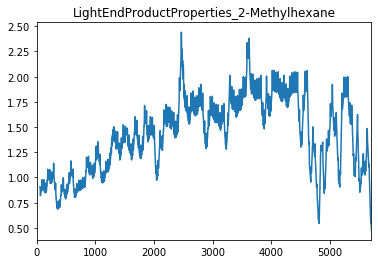

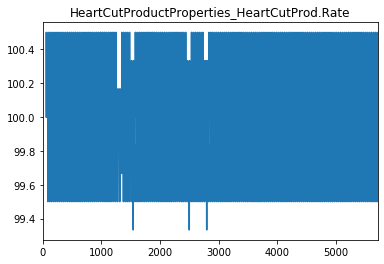

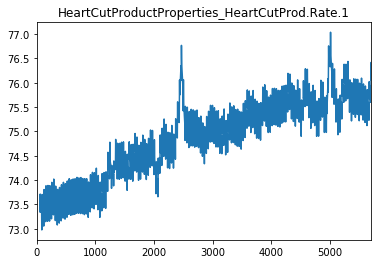

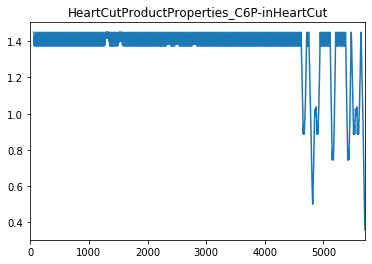

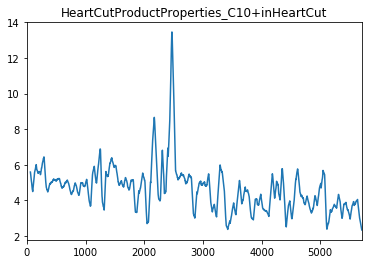

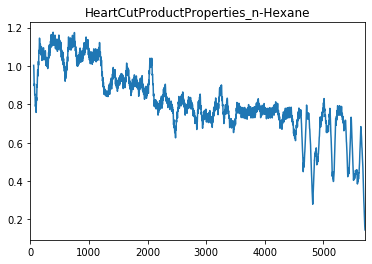

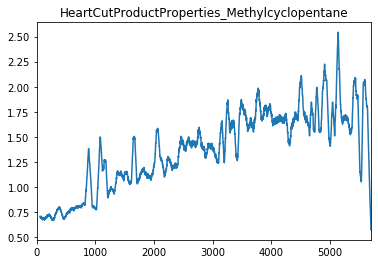

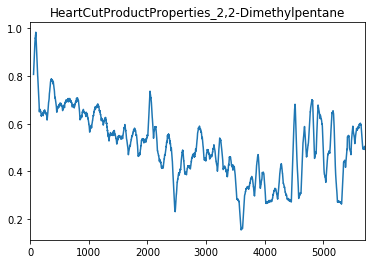

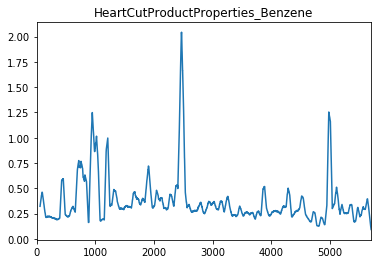

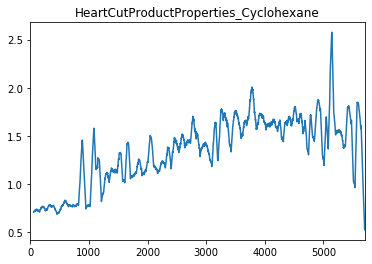

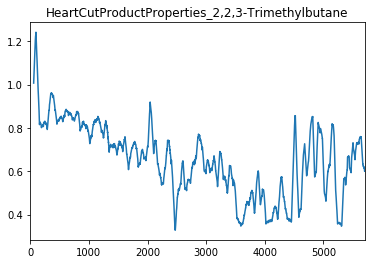

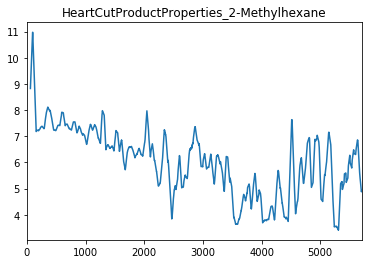

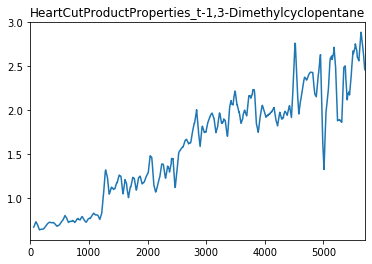

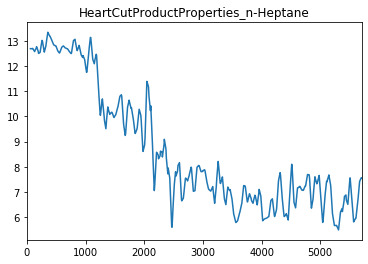

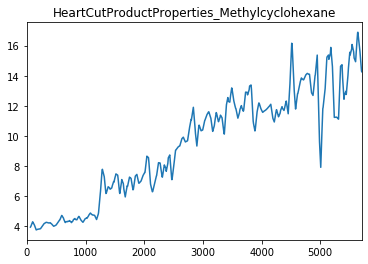

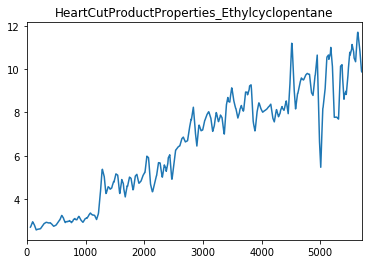

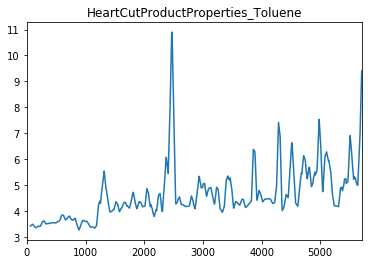

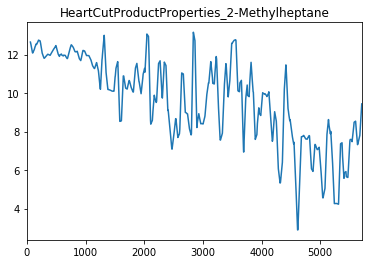

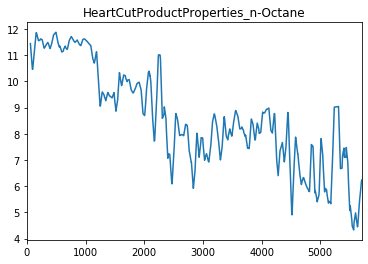

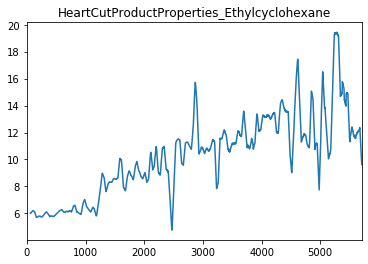

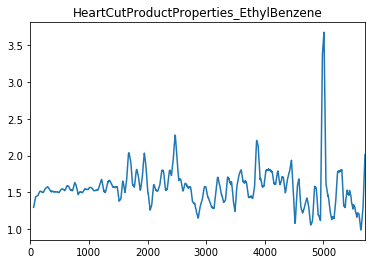

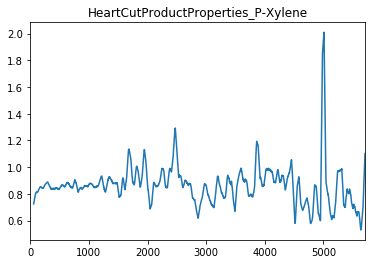

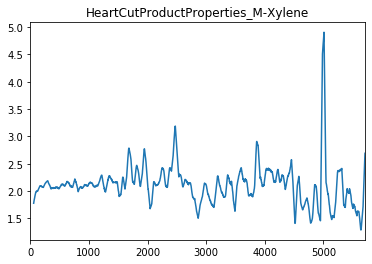

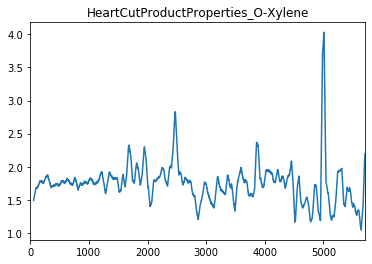

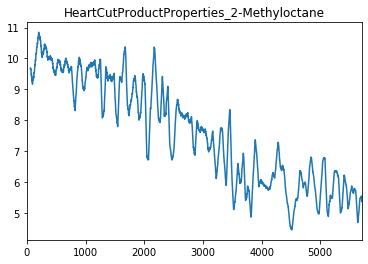

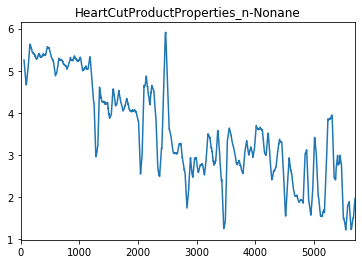

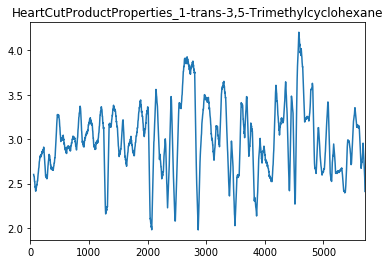

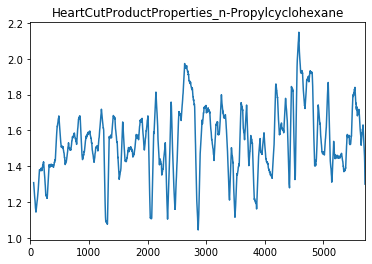

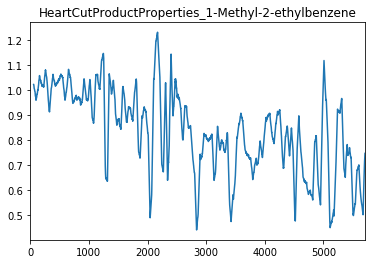

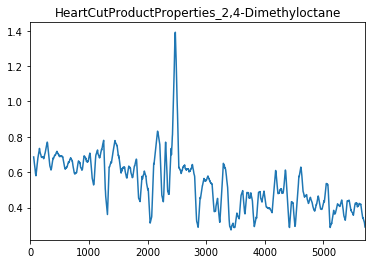

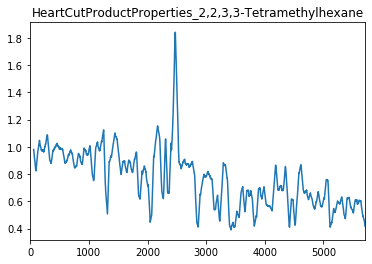

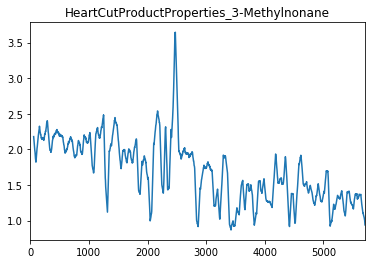

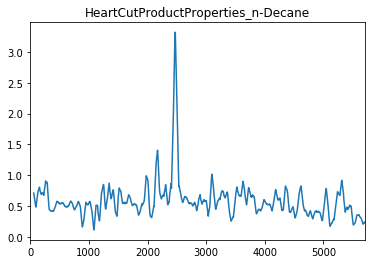

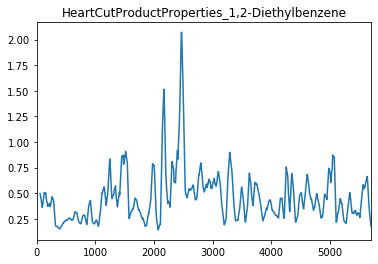

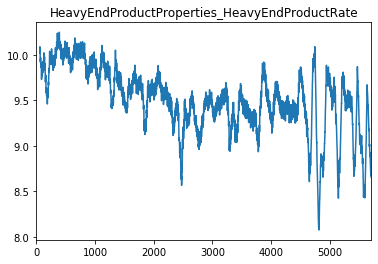

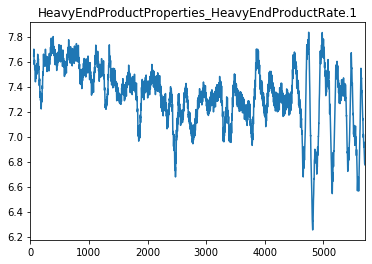

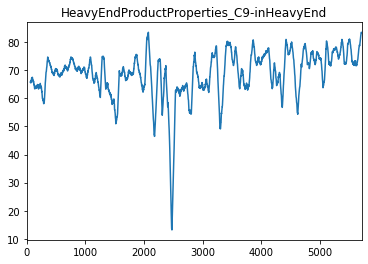

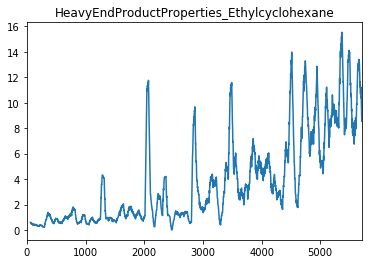

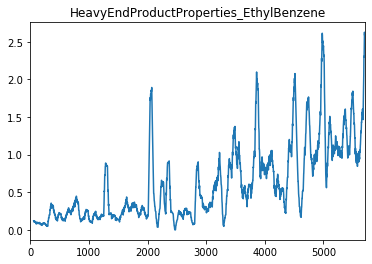

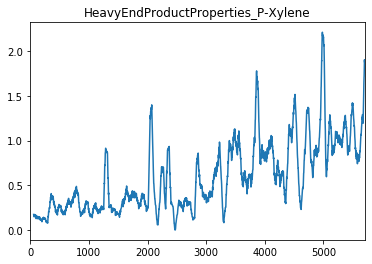

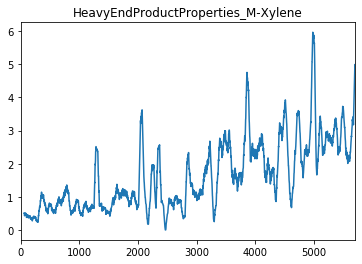

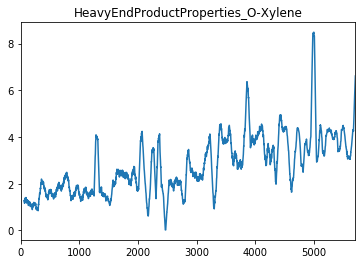

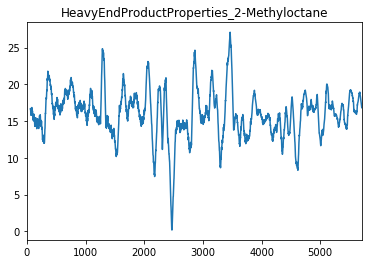

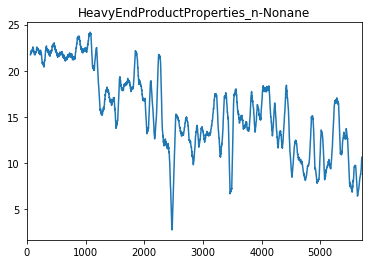

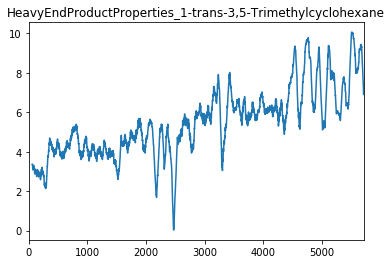

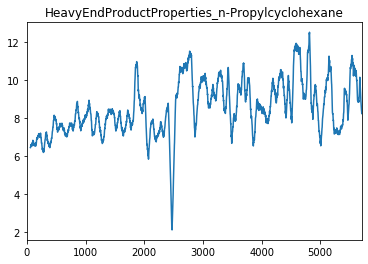

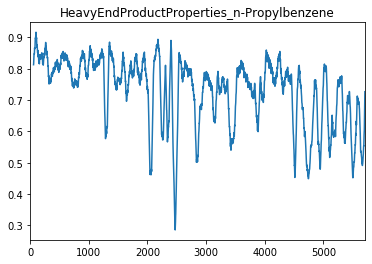

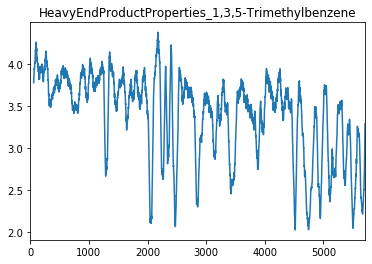

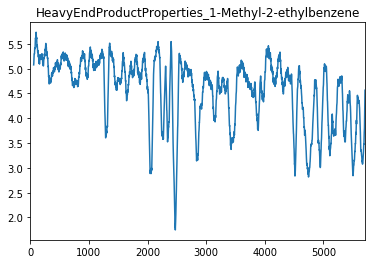

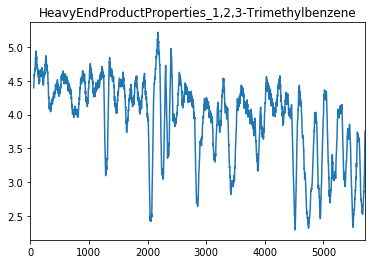

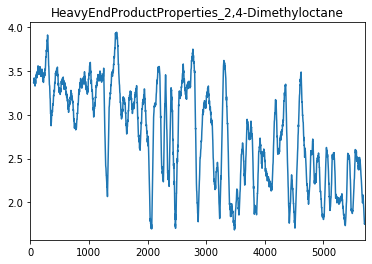

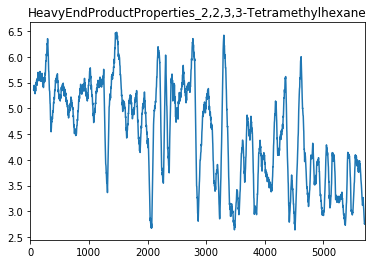

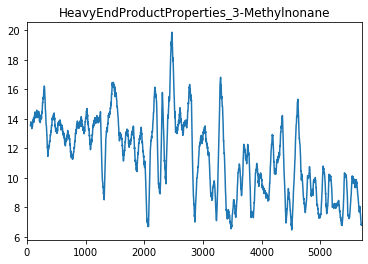

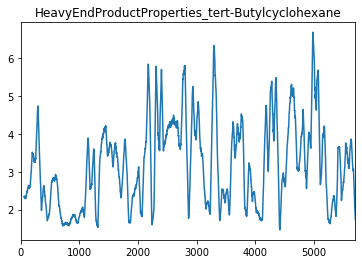

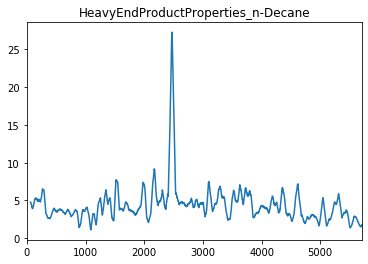

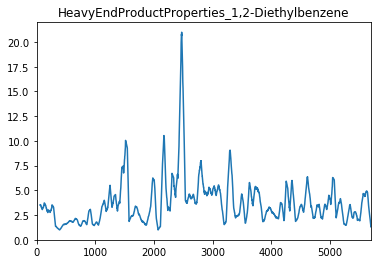

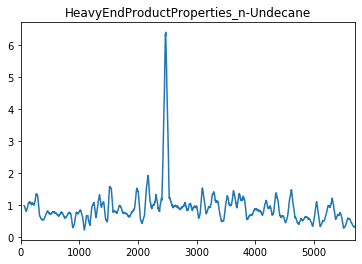

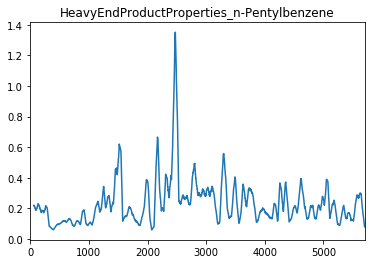

In [41]:
for i in t.loc[t.R2>=0.9].index:
    df[i].rolling(60).mean().plot()
    plt.title(i)
    plt.show()

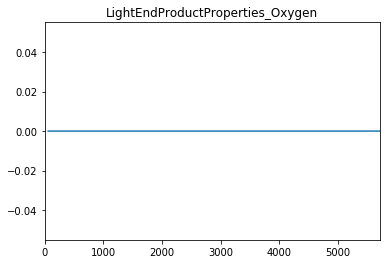

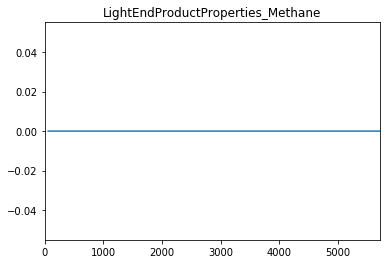

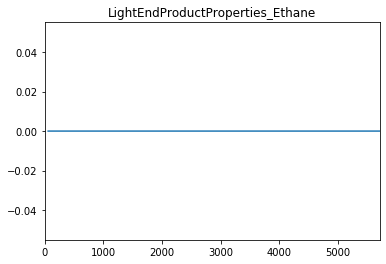

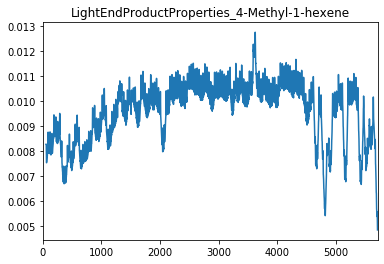

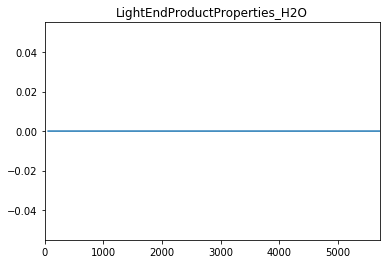

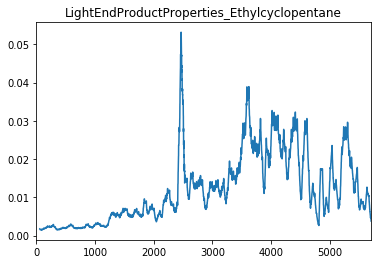

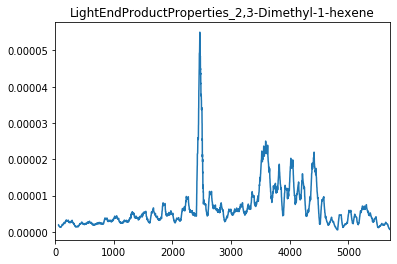

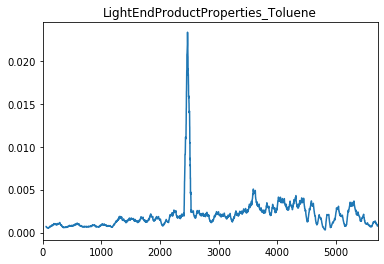

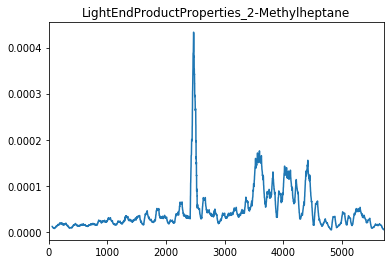

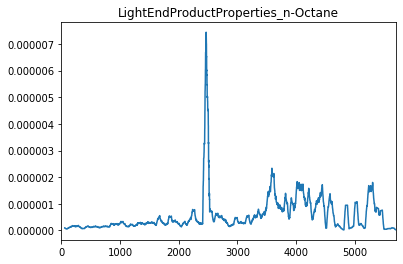

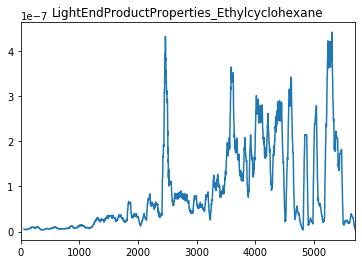

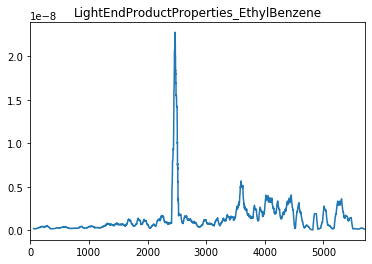

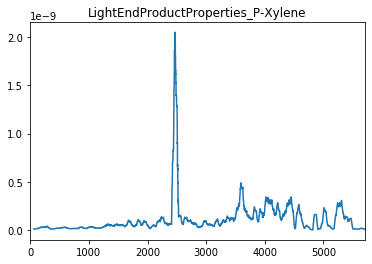

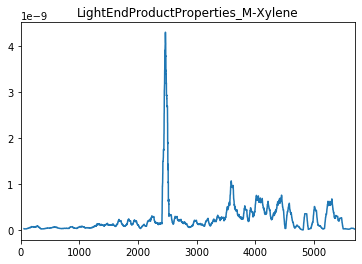

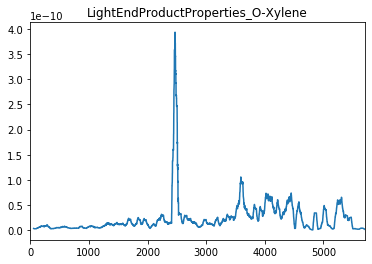

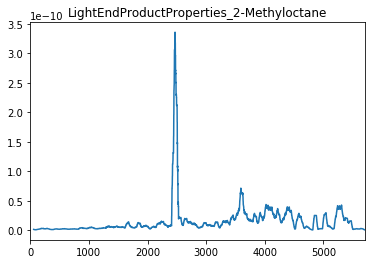

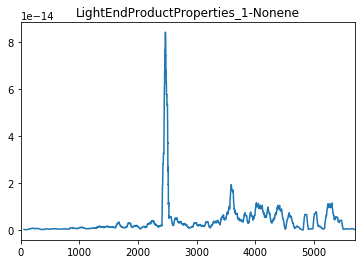

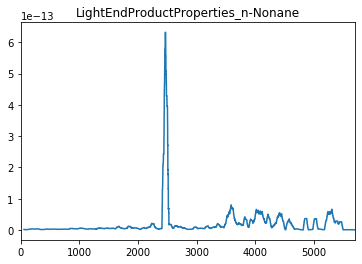

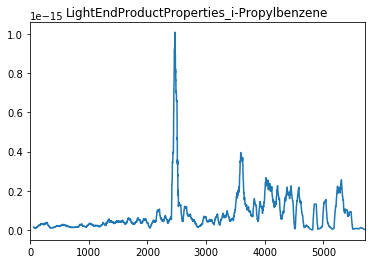

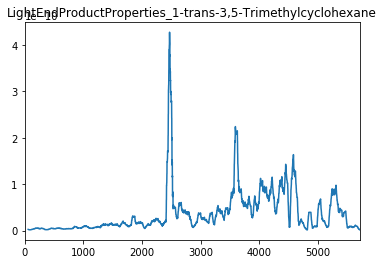

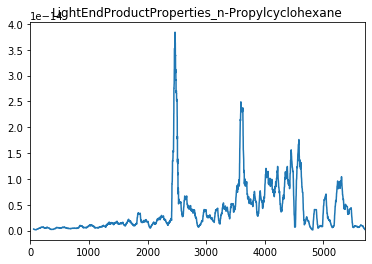

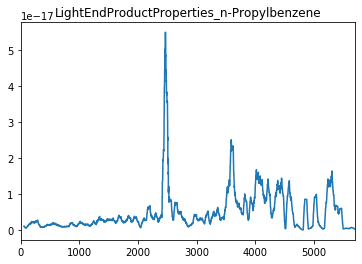

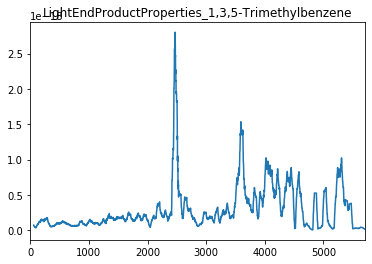

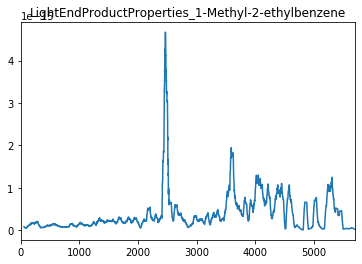

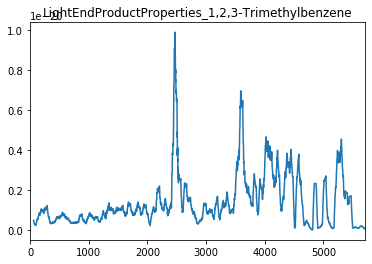

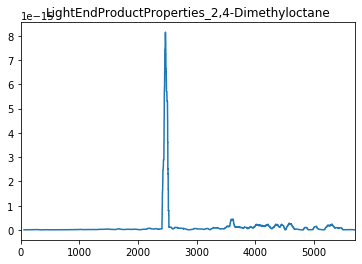

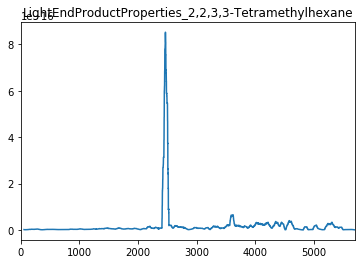

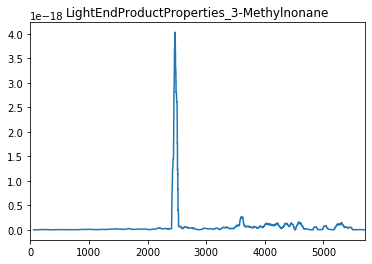

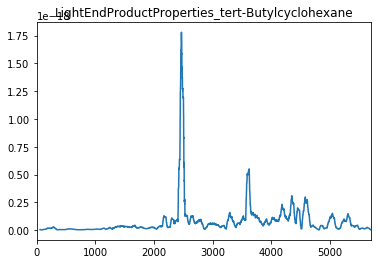

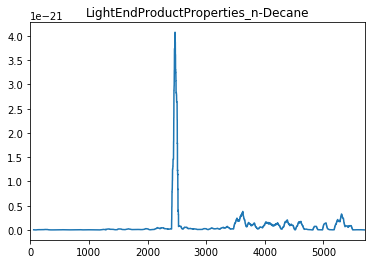

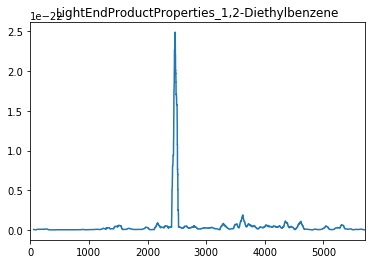

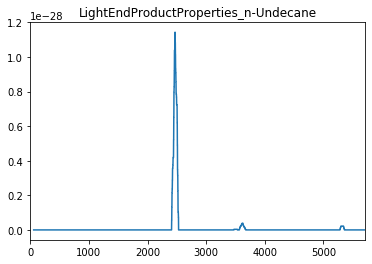

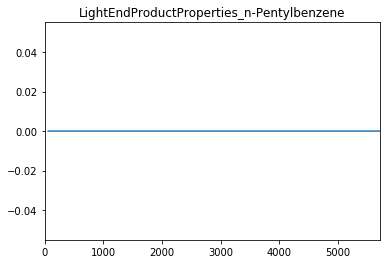

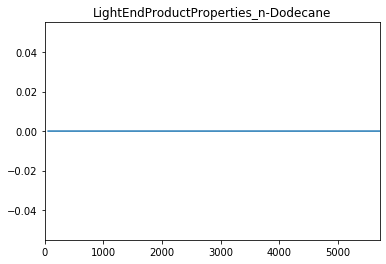

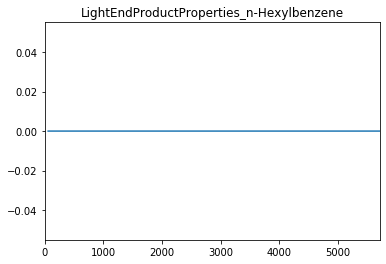

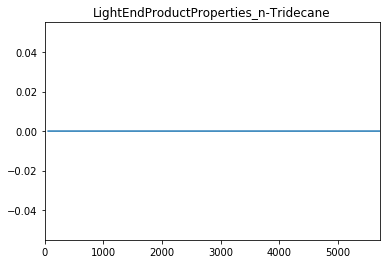

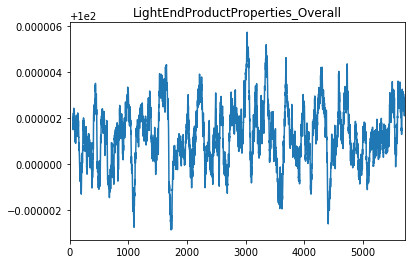

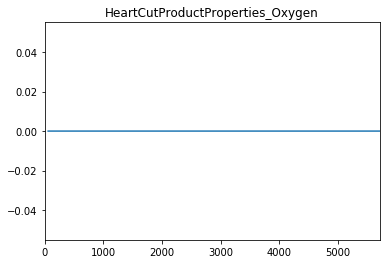

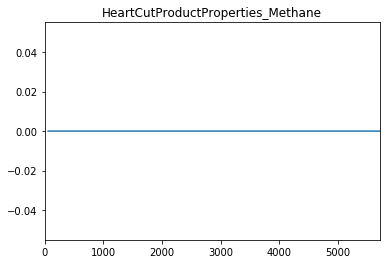

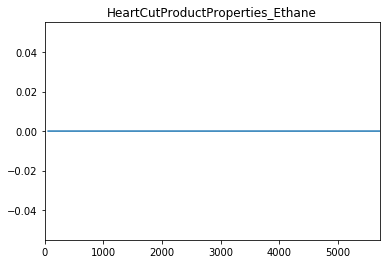

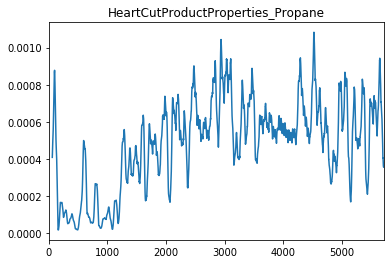

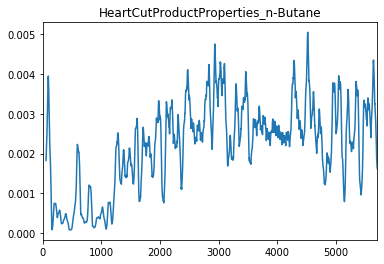

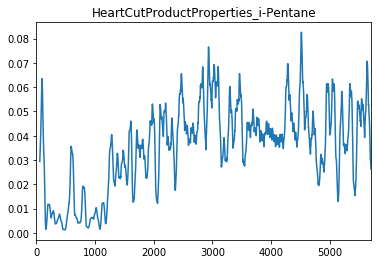

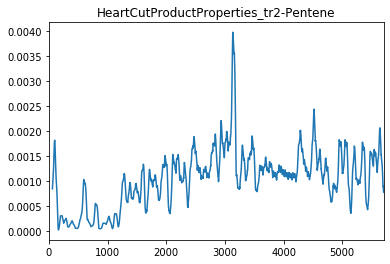

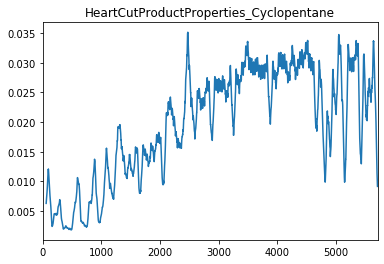

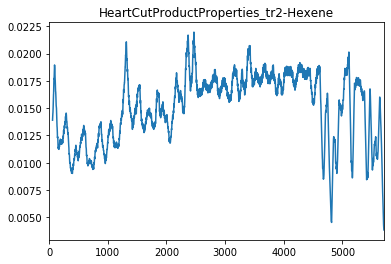

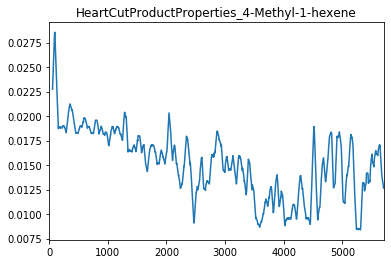

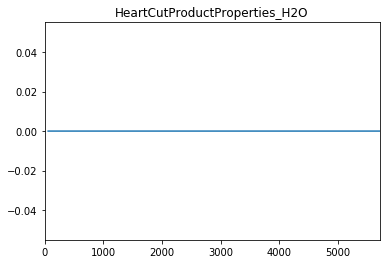

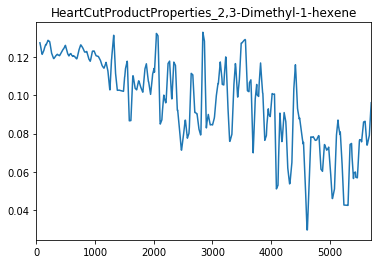

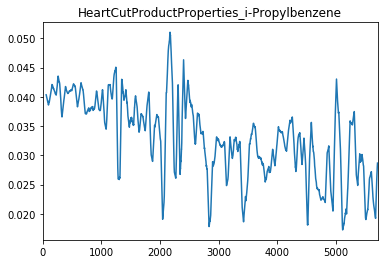

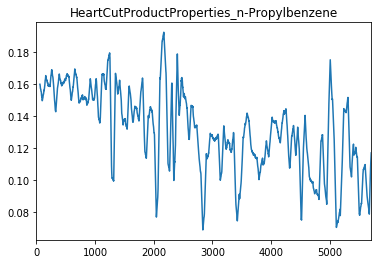

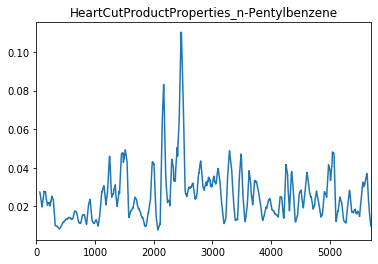

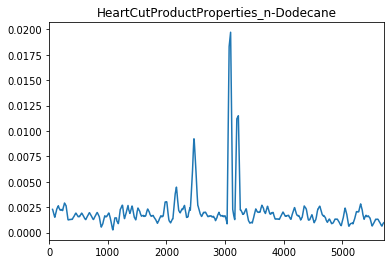

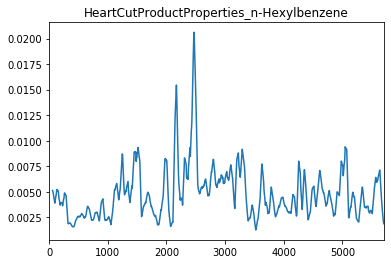

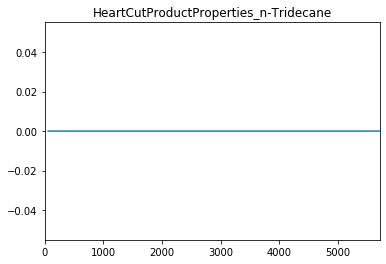

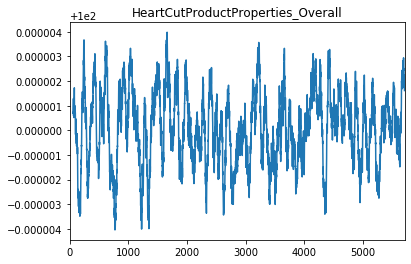

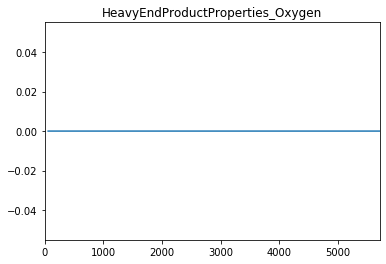

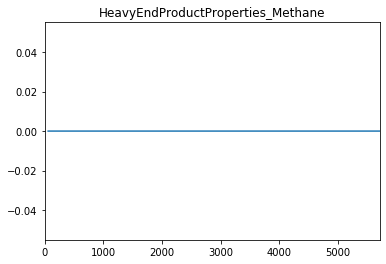

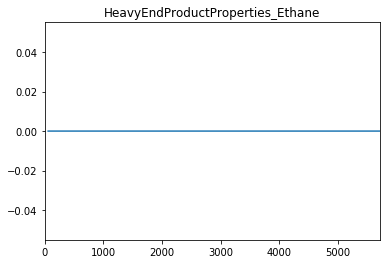

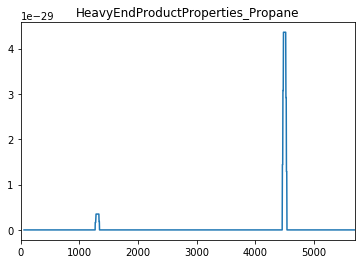

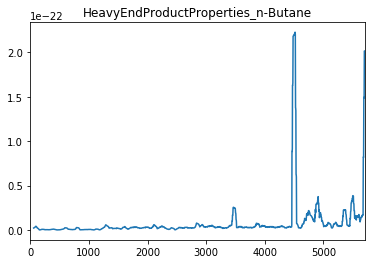

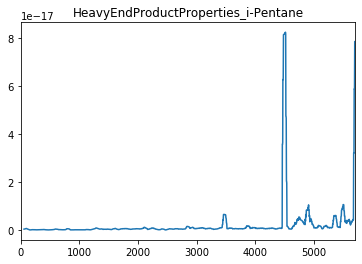

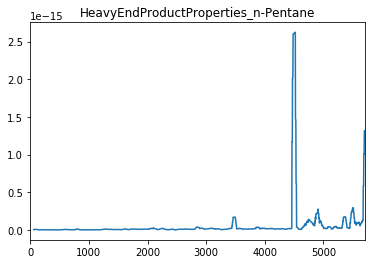

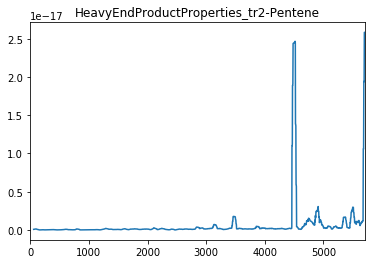

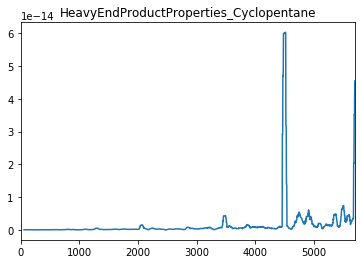

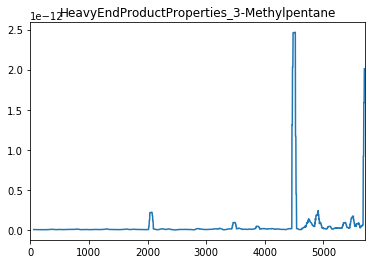

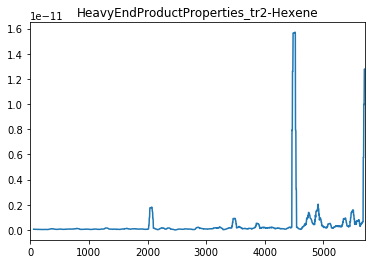

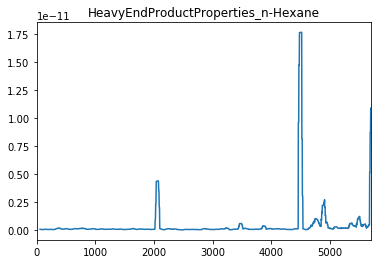

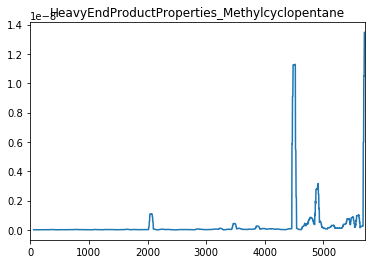

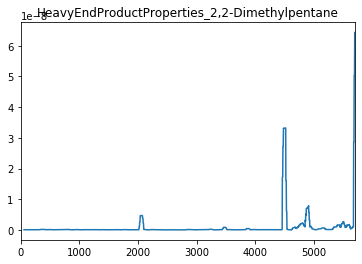

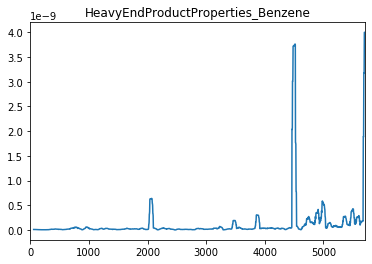

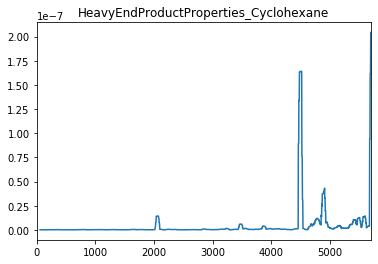

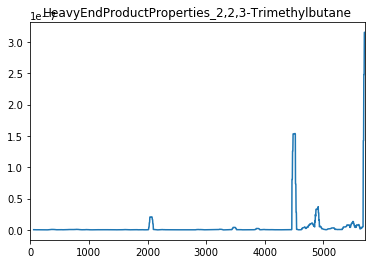

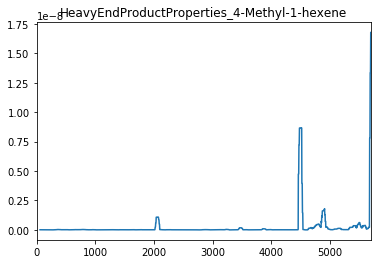

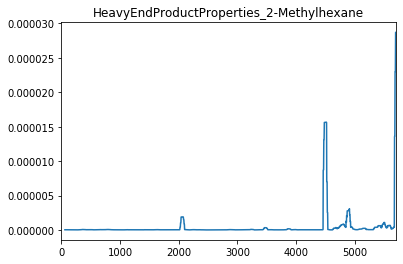

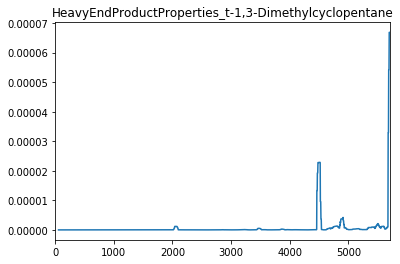

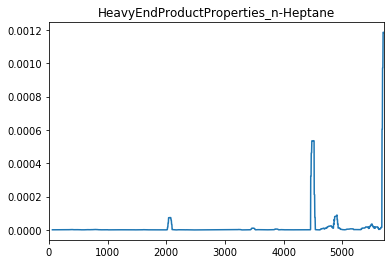

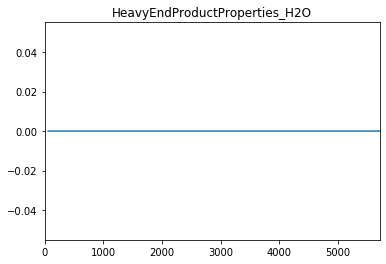

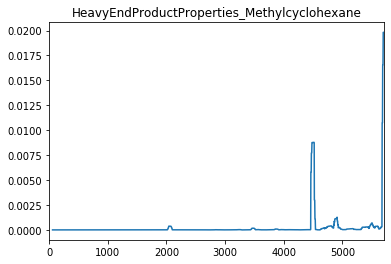

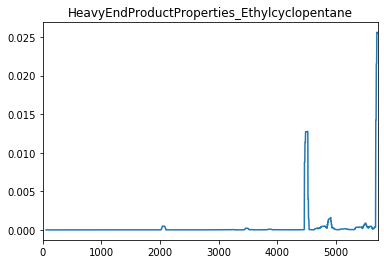

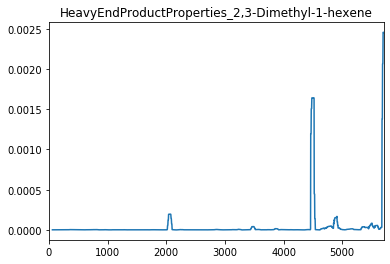

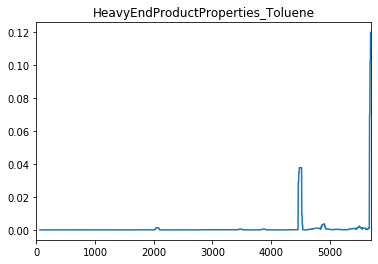

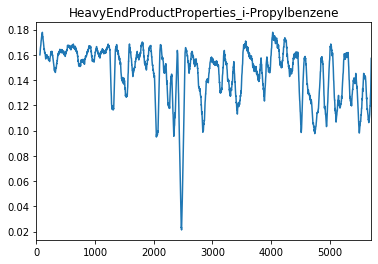

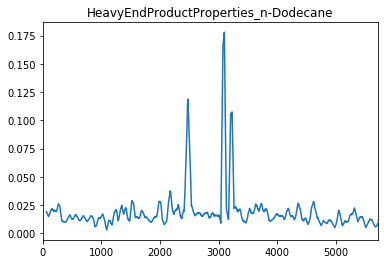

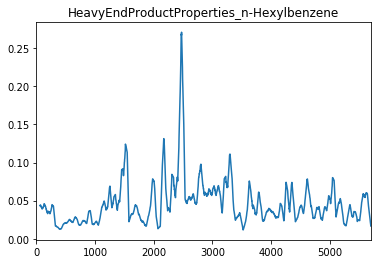

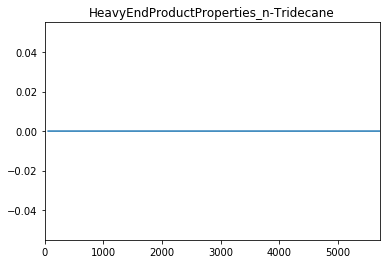

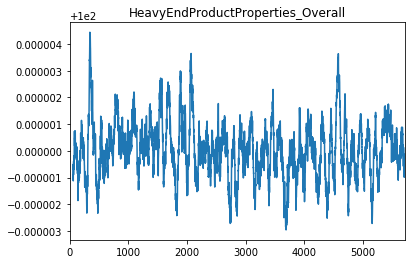

In [42]:
for i in t.loc[t.R2==0].index:
    df[i].rolling(60).mean().plot()
    plt.title(i)
    plt.show()